This Notebook builds a model that uses properties found by proteins grouping. Each datapoint of the train set consists of the comparision between the wildtype and a mutated protein. We use Blosum matrix to have the distance between the two aminoacids that change, the difference in pH. The difference in temperature is used as label. Those results are not combined with the protein's sequence here, and we only use a MLP.

In [284]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn import metrics

import os
from collections import Counter

from helpers import *

In [285]:
import blosum as bl
matrix = bl.BLOSUM(62)

1. Load the dataset 

In [286]:
#load training data (will be put in a function later) 
#TO CHANGE
path = os.getcwd()
for i in range(3) :

    path = os.path.dirname(path)

path += '/data/'
train_df = pd.read_csv(path + 'clean_train_data.csv')
train_df = train_df.drop(columns=['data_source1'])
train_df = train_df.drop(columns=['data_source2'])

train_df = train_df.drop(columns=['protSeq2'])
train_df = train_df.drop(columns=['tm1'])
train_df = train_df.drop(columns=['tm2'])
train_df = train_df.drop(columns=['group1'])
train_df = train_df.drop(columns=['group2'])

train_df = train_df.dropna()

train_df.head()
#dT = 'target'

,protSeq1,operation,position1,position2,change1,change2,pH1,pH2,target
0,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,D,6.5,6.5,-6.7
1,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,E,6.5,6.5,-3.9
2,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,F,6.5,6.5,-1.2
3,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,G,6.5,6.5,-4.0
4,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,replace,2,2,A,L,6.5,6.5,2.7


In [287]:
test_df = pd.read_csv(path+ 'test_mutations.csv', index_col="seq_id")
test_df = test_df.drop(columns=['data_source'])
test_df = test_df.drop(columns=['b_factor'])
test_df = test_df.drop(columns=['bFactorAdj'])
test_df = test_df.drop(columns=['score'])
test_df = test_df.drop(columns=['position1'])
test_df = test_df.drop(columns=['position2'])

test_df.head()

,protein_sequence,pH,modif,score_adj,operation,change1,change2
seq_id,,,,,,,
31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,16,0.880797,replace,E,L
31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,16,0.880797,replace,K,L
31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,16,0.999955,delete,K,NaN
31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,17,0.952574,replace,C,K
31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,17,0.952574,replace,F,K


2. Modify the dataset to have the features needed

In [288]:
test_df['length'] = test_df['protein_sequence'].str.len()
test_df = test_df.drop(columns=['protein_sequence'])

In [289]:
train_df = train_df[train_df['operation']=='replace']

In [290]:
#add a new column that contains the length of each protein sequence (before padding)
train_df['length'] = train_df['protSeq1'].str.len()
train_df = train_df.drop(columns=['protSeq1'])

In [291]:
#Put the distance of the 2 aa as a feature, with blosum: 
#hypothesis : this score influences the delta Tm. 
#Allows to encode the "mutation" and the info : which aa into which aa

def blosum_apply(row):
        if (row['operation']=='replace'):
            res = matrix[row['change1'] + row['change2']]
        else:
                res = -10
        return res

train_df['dist_mutation'] = train_df.apply(blosum_apply, axis=1)
test_df['dist_mutation'] = test_df.apply(blosum_apply, axis=1)    

In [292]:
test_df = test_df.drop(columns=['change1'])
test_df = test_df.drop(columns=['change2'])


In [293]:
train_df = train_df.drop(columns=['change1'])
train_df = train_df.drop(columns=['change2'])

In [294]:
train_df.head()

,operation,position1,position2,pH1,pH2,target,length,dist_mutation
0,replace,2,2,6.5,6.5,-6.7,164,-2.0
1,replace,2,2,6.5,6.5,-3.9,164,-1.0
2,replace,2,2,6.5,6.5,-1.2,164,-2.0
3,replace,2,2,6.5,6.5,-4.0,164,0.0
4,replace,2,2,6.5,6.5,2.7,164,-1.0


In [295]:
test_df.head()

,pH,modif,score_adj,operation,length,dist_mutation
seq_id,,,,,,
31390,8,16,0.880797,replace,221,-3.0
31391,8,16,0.880797,replace,221,-2.0
31392,8,16,0.999955,delete,220,-10.0
31393,8,17,0.952574,replace,221,-3.0
31394,8,17,0.952574,replace,221,-3.0


In [296]:
#Compute the relative position of the mutation

train_df['relative_position'] = train_df['position1']/train_df['length']
train_df = train_df.drop(columns=['position1'])
train_df = train_df.drop(columns=['position2'])

In [297]:
test_df['relative_position'] = test_df['modif']/test_df['length']
test_df = test_df.drop(columns=['modif'])

In [298]:
train_df.head()

,operation,pH1,pH2,target,length,dist_mutation,relative_position
0,replace,6.5,6.5,-6.7,164,-2.0,0.012195
1,replace,6.5,6.5,-3.9,164,-1.0,0.012195
2,replace,6.5,6.5,-1.2,164,-2.0,0.012195
3,replace,6.5,6.5,-4.0,164,0.0,0.012195
4,replace,6.5,6.5,2.7,164,-1.0,0.012195


In [299]:
test_df.head()


,pH,score_adj,operation,length,dist_mutation,relative_position
seq_id,,,,,,
31390,8,0.880797,replace,221,-3.0,0.072398
31391,8,0.880797,replace,221,-2.0,0.072398
31392,8,0.999955,delete,220,-10.0,0.072727
31393,8,0.952574,replace,221,-3.0,0.076923
31394,8,0.952574,replace,221,-3.0,0.076923


In [300]:
#Compute difference of pH
train_df['dPH'] = train_df['pH1']-train_df['pH2']
train_df = train_df.drop(columns=['pH1'])
train_df = train_df.drop(columns=['pH2'])

test_df['dPH'] =test_df['pH'] - 8
test_df = test_df.drop(columns=['pH'])

In [301]:
train_df.head()

,operation,target,length,dist_mutation,relative_position,dPH
0,replace,-6.7,164,-2.0,0.012195,0.0
1,replace,-3.9,164,-1.0,0.012195,0.0
2,replace,-1.2,164,-2.0,0.012195,0.0
3,replace,-4.0,164,0.0,0.012195,0.0
4,replace,2.7,164,-1.0,0.012195,0.0


In [303]:
test_df = test_df.drop(columns=['score_adj'])

In [305]:
test_df.head()

,length,dist_mutation,relative_position,dPH
seq_id,,,,
31390,221,-3.0,0.072398,0
31391,221,-2.0,0.072398,0
31392,220,-10.0,0.072727,0
31393,221,-3.0,0.076923,0
31394,221,-3.0,0.076923,0


Final set

In [306]:
train_df.head()

,operation,target,length,dist_mutation,relative_position,dPH
0,replace,-6.7,164,-2.0,0.012195,0.0
1,replace,-3.9,164,-1.0,0.012195,0.0
2,replace,-1.2,164,-2.0,0.012195,0.0
3,replace,-4.0,164,0.0,0.012195,0.0
4,replace,2.7,164,-1.0,0.012195,0.0


In [307]:
df = train_df.copy()

In [308]:
df = df.reset_index(drop=True)

In [309]:
test_df = test_df.reset_index(drop=True)

3. Split to train and validation sets

In [310]:
#split padded_train_df into train and validation sets (will be put in a function later)
train_df , val_df = split_train_test(df,frac=0.8)

train_df has shape : (1837, 6) 
 test_df has shape :  (459, 6)


4. Model 

In [311]:
class EnzymesDataset(Dataset):
 
    def __init__(self,df,train=True):
    
        
        # numerical : pH and length
        numerical = df[['dPH','length', 'relative_position', 'dist_mutation']].values

        # y : the target (tm)
        if train == True : 
            y=df['target'].values
        else : 
            y = np.zeros(np.shape(numerical)[0])
        self.y=torch.tensor(y,dtype=torch.float32)
        #creta tensors from the numpy arrays
       
        self.num=torch.tensor(numerical,dtype=torch.float32)
   
 
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        return self.num[idx],self.y[idx]


In [312]:
# hyperparameters
batch_size = 64
learning_rate = 0.001 # Suggested for Adam
num_epochs = 200


In [313]:
#Create pytorch dataframes

train_d = EnzymesDataset(train_df)
val_d = EnzymesDataset(val_df)


# create pytorch dataloaders
train_dl = torch.utils.data.DataLoader(train_d, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_d, batch_size=batch_size, shuffle=True)

In [314]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
       
        
        self.numerical = nn.Sequential(
            nn.Linear(4, 20),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(20, 100),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(100, 200),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(200, 100),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(100, 1),
            
            
        )
       

    def forward(self, x):
        
        x = self.numerical(x.float())
       
        return x

In [315]:
model = Net()
optimizer = Adam(model.parameters(), lr=learning_rate)
# defining the loss function
criterion = nn.MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

5. KFold

In [316]:
from sklearn.model_selection import KFold


k_folds = 5
learning_rate = 1e-4
kfold = KFold(n_splits=k_folds, shuffle=True)
dataset = EnzymesDataset(df.reset_index(drop=True))
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    train_dl = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=32, sampler=train_subsampler)
    val_dl = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=32, sampler=test_subsampler)

    model = Conv1D_OneChannel()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # defining the loss function
    criterion = nn.MSELoss()
    # checking if GPU is available
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
    
    for epoch in range(1, num_epochs + 1):
        train_loss , rho_train = train_epoch( model, optimizer, criterion, train_dl, epoch)
       

        
    
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
        

    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)

    
    
    print(f'for fold {fold} : \n train_loss :  {train_loss}     test_loss : {test_loss} \n \n')
    
    
    
 


6. Train the model and create the plots

In [317]:
#Train and test functions, different from the usual one because 
#we don't have the sequence feature for this notebook
def train_epoch(model, optimizer, criterion, train_loader, epoch):
    model.train()
    rho = 0 
    train_loss = 0 
    for batch_idx, (num,target) in enumerate(train_loader):
        if torch.cuda.is_available():
           
            target = target.cuda()
            num = num.cuda()
        optimizer.zero_grad()
        
        output = model(num)
        loss = criterion(output.squeeze(), target)
        train_loss += loss.item()
        loss.backward()
        
        optimizer.step()
        # calculate Spearman's rank correlation coefficient
        p, _ = scipy.stats.spearmanr(target.cpu().detach().numpy(), output.squeeze().cpu().detach().numpy())
        rho += p
    
    train_loss /= len(train_loader)
    
    if epoch % 50 == 0 :
        print(   f"Train Epoch: {epoch} " f" loss={train_loss:0.2e} " )

    rho = rho / len(train_loader)
    return train_loss , rho


def test_epoch(model, criterion, test_loader):
    model = model.eval()
    test_loss = 0
    rho = 0
    with torch.no_grad():
        for num,target in test_loader:
            if torch.cuda.is_available():
                target = target.cuda()
                num = num.cuda()
            output = model(num)
            test_loss += criterion(output.squeeze(), target).item()  # sum up batch loss
            # calculate pearson correlation 
            #pearson, rmse, auc = Scoring(target.cpu().detach(), output.cpu().detach())
            p, _ =  scipy.stats.spearmanr(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            rho += p
            

    test_loss /= len(test_loader)
    rho = rho / len(test_loader)
    print(
        f"Test set: Average loss: {test_loss:0.2e} "
    )

    return test_loss ,rho


In [318]:
#train model and preditct
train_rho_history = []
train_loss_history = []
test_rho_history = []
test_loss_history = []
for epoch in range(1, num_epochs + 1):
    train_loss , rho_train = train_epoch(
        model, optimizer, criterion, train_dl, epoch
    )
    
    
    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)

   


Test set: Average loss: 7.01e+01 
Test set: Average loss: 7.26e+01 
Test set: Average loss: 7.39e+01 
Test set: Average loss: 8.35e+01 
Test set: Average loss: 7.29e+01 
Test set: Average loss: 7.20e+01 
Test set: Average loss: 7.30e+01 
Test set: Average loss: 7.07e+01 
Test set: Average loss: 6.86e+01 
Test set: Average loss: 7.07e+01 
Test set: Average loss: 7.10e+01 
Test set: Average loss: 7.07e+01 
Test set: Average loss: 7.46e+01 
Test set: Average loss: 6.92e+01 
Test set: Average loss: 7.12e+01 
Test set: Average loss: 7.51e+01 
Test set: Average loss: 7.24e+01 
Test set: Average loss: 7.47e+01 
Test set: Average loss: 7.28e+01 
Test set: Average loss: 7.46e+01 
Test set: Average loss: 7.90e+01 
Test set: Average loss: 7.18e+01 
Test set: Average loss: 7.13e+01 
Test set: Average loss: 7.44e+01 
Test set: Average loss: 7.03e+01 
Test set: Average loss: 7.44e+01 
Test set: Average loss: 6.92e+01 
Test set: Average loss: 7.04e+01 
Test set: Average loss: 7.91e+01 
Test set: Aver

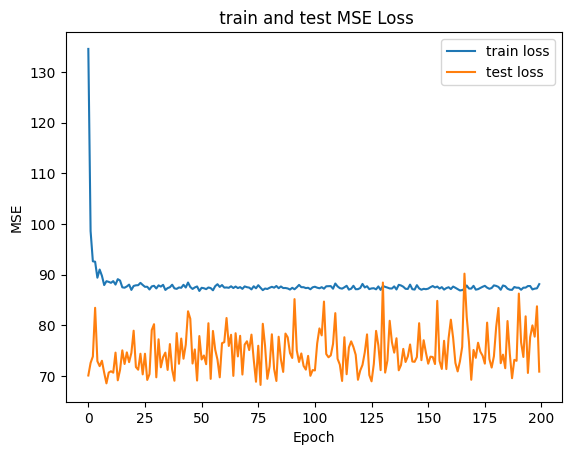

In [319]:
#create loss plot

plt.plot(train_loss_history, label='train loss')
plt.plot(test_loss_history, label='test loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title(' train and test MSE Loss')
plt.legend()
plt.savefig('7-Mutation_Alone_loss.png')


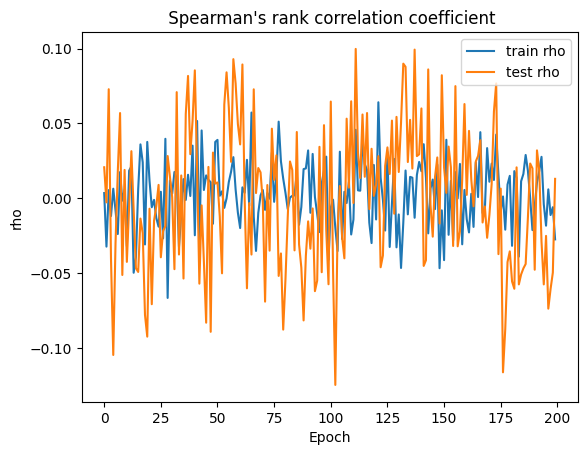

In [320]:
#Create Spearman's rank coefficient plot

plt.plot(train_rho_history, label='train rho')
plt.plot(test_rho_history, label='test rho')
plt.xlabel('Epoch')
plt.ylabel('rho')
plt.title(' Spearman\'s rank correlation coefficient')
plt.legend()
plt.savefig('7-Mutation_alone_rho.png')

In [321]:
torch.save(model.state_dict(), f"effect_mutation.pth")

8. Kaggle prediction

In [322]:
#Different prediction function since we don't have the sequence

def predict(model,test_loader):
    model = model.eval()
    preds = []
    with torch.no_grad():
        for num,target in test_loader:
            if torch.cuda.is_available():
                
                target = target.cuda()
                num = num.cuda()
            output = model(num)
            preds.append(output.to('cpu').numpy())
            
    output = np.concatenate(preds)
    return output


In [324]:
#Prediction for Kaggle's submission
test_d = EnzymesDataset(test_df, False)

# create pytorch dataloaders
sub_dl = torch.utils.data.DataLoader(test_d, batch_size=batch_size, shuffle=True)
submission_df =  predict(model,sub_dl)

In [326]:
sub = pd.read_csv(path+ 'test.csv',index_col='seq_id')
sub['tm']=submission_df
sub = sub.drop(columns=['protein_sequence','pH','data_source'])
sub.to_csv('7_mutations-alone.csv', index=True)